In [33]:
import numpy as np
import pandas as pd
import pickle

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
from keras import regularizers
import math

import random

# to make the experimens replicable
random.seed(123456)

## Important

as first step run the notebook `1. classification-dataset-creation.ipynb` to create the dataset.

In [4]:
dataset_path = 'regione-toscana/dataset-dirigenti.pkl'

with open(dataset_path, 'rb') as f:
    samples, labels = pickle.load(f)

### Transform it in a dataset

In [5]:
samples[:5]

array(["DGR 968/07 e s.m.i. Accreditamento degli organismi formativi. Rilascio dell'accreditamento all'organismo formativo Bioscience Research Center - cod. GR1035.",
       'Nomina Commissione d’esame per il percorso formativo “Formazione obbligatoria per utilizzatori professionali di prodotti fitosanitari”, MATRICOLA N. 2016SI0046',
       "Nomina della Commissione d'esame matricola 2016PI0301. Agenzia Formativa Cescot",
       'Progetti formativi per drop-out a.s.f. 2015-2016. Integrazione impegno per progetto "Figaro - Operatore del benessere (acconciatura)"',
       'REG (CE) 1080/2006-Por Creo Fesr 2007-2013-Linea di intevento 5.1.d-Chiusura attività'],
      dtype='<U961')

In [6]:
labels[:5]

array(['50125', '50125', '50125', '50125', '50125'], dtype='<U5')

In [7]:
samples = np.array(samples)
labels = np.array(labels)

## Train and Test Set

Normally we split the dataset into:
- 80% for training (of which 10% for validation)
- 20% for testing

In [8]:
samples.shape

(147463,)

### Shuffle Data

In [9]:
indices = list(range(len(samples)))
np.random.shuffle(indices)

samples = samples[indices]
labels = labels[indices]

In [10]:
labels[:5]

array(['50117', '50006', '01928', '50102', '50004'], dtype='<U5')

## Tokenize the Dataset

In [11]:
from keras.preprocessing.text import Tokenizer

In [12]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(samples)

In [13]:
sequences = tokenizer.texts_to_sequences(samples)

In [15]:
for s in sequences[:2]:
    print(s) 

[7, 6, 24, 327, 23, 335, 33, 63, 1, 218, 228, 449, 1517, 1, 795, 1507, 345, 339, 143, 1072, 678]
[28, 132, 6, 128, 24, 181, 19, 2, 48, 42, 317, 1244, 4, 7, 723, 126, 78, 14, 101, 1427, 6036, 7188, 291, 1966, 17]


Convert labels to sequences

In [16]:
index_to_labels = dict(enumerate(set(labels)))
labels_to_index = {v:k for k,v in index_to_labels.items()}

In [18]:
list(labels_to_index.items())[:5]

[('50079', 0), ('01937', 1), ('50116', 2), ('01934', 3), ('50003', 4)]

In [19]:
len(labels_to_index)

32

In [20]:
encoded_labels = [labels_to_index[l] for l in labels]

In [21]:
encoded_labels[:10]

[9, 27, 30, 14, 22, 4, 12, 4, 0, 20]

### Split the dataset

In [22]:
training_size = math.trunc(len(sequences) * 0.8)
test_size = len(sequences)

In [23]:
train_data = sequences[:training_size]
train_labels = encoded_labels[:training_size]

test_data = sequences[training_size:]
test_labels = encoded_labels[training_size:] 

### Preparing Data

for data and labels

In [24]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [26]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [27]:
x_train[0:]

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
x_train.shape

(117970, 10000)

One hot encoding for the labels

In [29]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float32)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [31]:
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [32]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Build the Models

apart the base model we add new methods with different kind of regularizers. In particular, we take into account:
- l2 that penalize the weights coefficient with a value proportional of their l1 and l2 norms. The general idea is that we prefer a simple model where the distribution of parameters values has less entropy.
- dropout where the idea is to reset randomly a percentage of the weights to zero in order to avoid that neurons start to memorize noise patterns.

In [34]:
def build_model(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [51]:
def build_model_l2(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(), input_shape=(x_train.shape[-1], )))
    model.add(layers.Dense(neurons, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dense(neurons, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [85]:
def build_model_dropout(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [93]:
model_base = build_model(256)

In [52]:
model_l2 = build_model_l2(256)

In [86]:
model_dropout = build_model_dropout(256)

In [94]:
history_base = model_base.fit(x=x_train, y=y_train, validation_split=0.2,
                   epochs=20, batch_size=256)

Train on 94376 samples, validate on 23594 samples
Epoch 1/20
94376/94376 [==============================] - 5s 49us/step - loss: 1.0785 - acc: 0.6672 - val_loss: 0.6854 - val_acc: 0.7693
Epoch 2/20
94376/94376 [==============================] - 4s 45us/step - loss: 0.4886 - acc: 0.8290 - val_loss: 0.6228 - val_acc: 0.7864
Epoch 3/20
94376/94376 [==============================] - 4s 45us/step - loss: 0.3215 - acc: 0.8854 - val_loss: 0.6618 - val_acc: 0.7909
Epoch 4/20
94376/94376 [==============================] - 4s 45us/step - loss: 0.2225 - acc: 0.9213 - val_loss: 0.6914 - val_acc: 0.7999
Epoch 5/20
94376/94376 [==============================] - 4s 45us/step - loss: 0.1643 - acc: 0.9427 - val_loss: 0.7579 - val_acc: 0.7980
Epoch 6/20
94376/94376 [==============================] - 4s 45us/step - loss: 0.1259 - acc: 0.9576 - val_loss: 0.8003 - val_acc: 0.7995
Epoch 7/20
94376/94376 [==============================] - 4s 47us/step - loss: 0.1046 - acc: 0.9642 - val_loss: 0.8596 - val_acc

In [53]:
history_l2 = model_l2.fit(x=x_train, y=y_train,  validation_split=0.2,
                   epochs=20, batch_size=256)

Train on 94376 samples, validate on 23594 samples
Epoch 1/20
94376/94376 [==============================] - 5s 56us/step - loss: 1.9488 - acc: 0.5892 - val_loss: 1.5740 - val_acc: 0.6722
Epoch 2/20
94376/94376 [==============================] - 5s 50us/step - loss: 1.5251 - acc: 0.6940 - val_loss: 1.5062 - val_acc: 0.6994
Epoch 3/20
94376/94376 [==============================] - 5s 51us/step - loss: 1.4596 - acc: 0.7195 - val_loss: 1.4736 - val_acc: 0.7220
Epoch 4/20
94376/94376 [==============================] - 5s 50us/step - loss: 1.3988 - acc: 0.7376 - val_loss: 1.4244 - val_acc: 0.7282
Epoch 5/20
94376/94376 [==============================] - 5s 50us/step - loss: 1.3509 - acc: 0.7494 - val_loss: 1.3851 - val_acc: 0.7421
Epoch 6/20
94376/94376 [==============================] - 5s 50us/step - loss: 1.3010 - acc: 0.7599 - val_loss: 1.3391 - val_acc: 0.7474
Epoch 7/20
94376/94376 [==============================] - 5s 50us/step - loss: 1.2561 - acc: 0.7707 - val_loss: 1.3406 - val_acc

In [87]:
history_dropout = model_dropout.fit(x=x_train, y=y_train,  validation_split=0.2,
                   epochs=20, batch_size=256)

Train on 94376 samples, validate on 23594 samples
Epoch 1/20
94376/94376 [==============================] - 5s 51us/step - loss: 1.7034 - acc: 0.4911 - val_loss: 0.8236 - val_acc: 0.7303
Epoch 2/20
94376/94376 [==============================] - 4s 46us/step - loss: 0.8712 - acc: 0.7141 - val_loss: 0.6736 - val_acc: 0.7719
Epoch 3/20
94376/94376 [==============================] - 4s 47us/step - loss: 0.6827 - acc: 0.7707 - val_loss: 0.6237 - val_acc: 0.7865
Epoch 4/20
94376/94376 [==============================] - 5s 48us/step - loss: 0.5790 - acc: 0.8035 - val_loss: 0.6032 - val_acc: 0.7948
Epoch 5/20
94376/94376 [==============================] - 4s 46us/step - loss: 0.5047 - acc: 0.8288 - val_loss: 0.5979 - val_acc: 0.8008
Epoch 6/20
94376/94376 [==============================] - 4s 46us/step - loss: 0.4535 - acc: 0.8457 - val_loss: 0.6053 - val_acc: 0.8022
Epoch 7/20
94376/94376 [==============================] - 4s 46us/step - loss: 0.4130 - acc: 0.8593 - val_loss: 0.6024 - val_acc

### Printing The Loss

In [56]:
import matplotlib.pyplot as plt

%matplotlib inline

In [77]:
def chart_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0,2, step=0.2))
    plt.legend()
    plt.show()

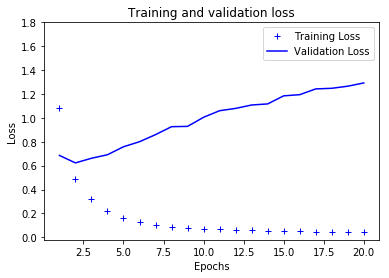

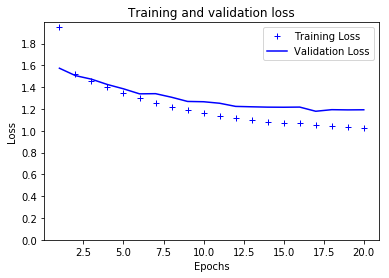

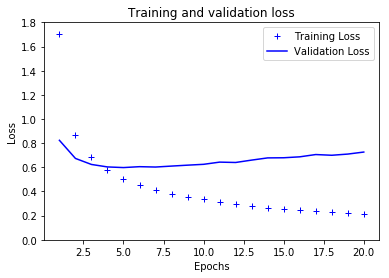

In [95]:
chart_loss(history_base)
chart_loss(history_l2)
chart_loss(history_dropout)

From the charts we can see that: 
- the model with l2 regularization is able to avoid overfitting during the training. 
- the model that uses dropout (0.5) has a lower loss with respect to l2 while combatting overfitting

In [104]:
def chart_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.yticks(np.arange(0.5,1, step=0.05))
    plt.xticks(np.arange(0,21, step=1))
    plt.legend()
    plt.show()

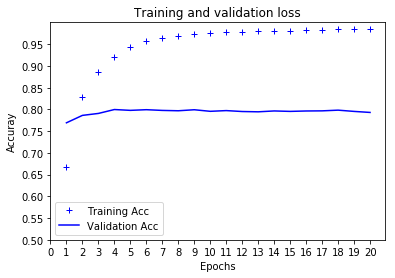

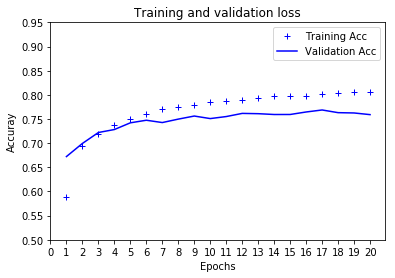

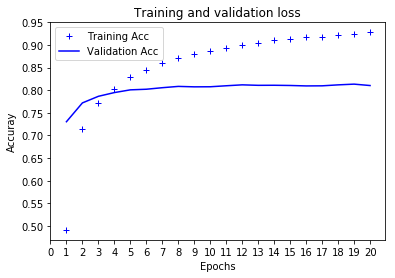

In [105]:
chart_acc(history_base)
chart_acc(history_l2)
chart_acc(history_dropout)

From the chart above we can see that the best model is the model that uses dropout, while the best epoch is the 6 where the validation accuracy crosses the training accuracy

In [106]:
def compare_loss(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_loss']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Validation Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

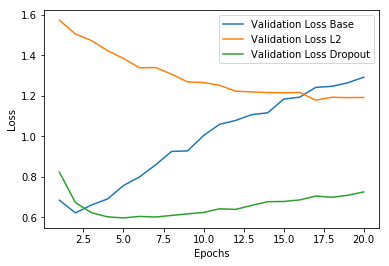

In [107]:
compare_loss({'Base': history_base, 'L2': history_l2, 'Dropout': history_dropout})

In [99]:
def compare_accuracy(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_acc']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_acc']
        plt.plot(epochs, val_loss, label='Validation Accuracy {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

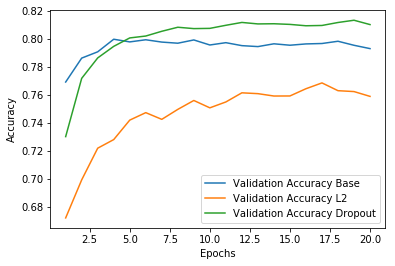

In [101]:
compare_accuracy({'Base': history_base, 'L2': history_l2, 'Dropout': history_dropout})

### Evaluate on the Test Set

- train the best model for the best epochs

In [108]:
model = build_model_dropout(256)

In [109]:
history = model.fit(x=x_train, y=y_train, epochs=6, batch_size=256)

Epoch 1/6
117970/117970 [==============================] - 5s 46us/step - loss: 1.5539 - acc: 0.5288
Epoch 2/6
117970/117970 [==============================] - 5s 42us/step - loss: 0.8202 - acc: 0.7278
Epoch 3/6
117970/117970 [==============================] - 5s 43us/step - loss: 0.6572 - acc: 0.7779
Epoch 4/6
117970/117970 [==============================] - 5s 43us/step - loss: 0.5604 - acc: 0.8081
Epoch 5/6
117970/117970 [==============================] - 5s 43us/step - loss: 0.4974 - acc: 0.8291
Epoch 6/6
117970/117970 [==============================] - 5s 43us/step - loss: 0.4530 - acc: 0.8441


In [110]:
loss, acc = model.evaluate(x_test, y_test)

29493/29493 [==============================] - 2s 55us/step


In [111]:
print('loss {}'.format(loss))
print('acc {}'.format(acc))

loss 0.5721056718917723
acc 0.8114467839887028


## Conclusion

As recap we can see that using regularization, in particular dropout, the accuracy grows from 0.78 to 0.81 %.